In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.simplefilter(action = 'ignore')

In [7]:
amzn = pd.read_csv("dataset/AMZN_2006-01-01_to_2018-01-01.csv")
googl = pd.read_csv("dataset/GOOGL_2006-01-01_to_2018-01-01.csv")
ibm = pd.read_csv("dataset/IBM_2006-01-01_to_2018-01-01.csv")
msft = pd.read_csv("dataset/MSFT_2006-01-01_to_2018-01-01.csv")
aapl = pd.read_csv("dataset/AAPL_2006-01-01_to_2018-01-01.csv")
intc = pd.read_csv("dataset/INTC_2006-01-01_to_2018-01-01.csv")
vz = pd.read_csv("dataset/VZ_2006-01-01_to_2018-01-01.csv")
amd = pd.read_csv("dataset/AMD.csv")
nvda = pd.read_csv("dataset/nvidia_all_time_daily_stock_prices.csv")
aaba = pd.read_csv("dataset/AABA_2006-01-01_to_2018-01-01.csv")

In [8]:
amd['Date'] = pd.to_datetime(amd['Date'])
nvda['Date'] = pd.to_datetime(nvda['Date'])
start_date = pd.to_datetime('2006-01-03')
end_date = pd.to_datetime('2017-12-29')
amd_crop = amd[(amd['Date'] >= start_date) & (amd['Date'] <= end_date)]
amd_crop = amd_crop.reset_index(drop=True)
amd_crop['Close'] = amd_crop['Close'].round(2)
nvda_crop = nvda[(nvda['Date'] >= start_date) & (nvda['Date'] <= end_date)]
nvda_crop = nvda_crop.reset_index(drop = True)
nvda_crop['Close'] = nvda_crop['Close'].round(2)

In [9]:
data = pd.concat([amzn[['Date','Close']], googl["Close"], msft["Close"], aapl["Close"], intc['Close'], 
                  nvda_crop['Close'], amd_crop['Close'], ibm["Close"], vz['Close'], aaba['Close']], axis = 1)
data.columns = ['Date', 'amzn', 'googl', 'msft', 'aapl', 'intc','nvda', 'amd', 'ibm', 'vz', 'aaba']
data['Date'] = pd.to_datetime(data['Date'])
data = data.drop(data.index[-1])
data

,Date,amzn,googl,msft,aapl,intc,nvda,amd,ibm,vz,aaba
0,2006-01-03,47.58,217.83,26.84,10.68,25.57,3.18,32.40,82.06,30.38,40.91
1,2006-01-04,47.25,222.84,26.97,10.71,25.91,3.27,32.56,81.95,31.27,40.97
2,2006-01-05,47.65,225.85,26.99,10.63,26.27,3.35,33.68,82.50,31.63,41.53
3,2006-01-06,47.87,233.06,26.91,10.90,26.31,3.40,33.78,84.95,31.35,43.21
4,2006-01-09,47.08,233.68,26.86,10.86,26.47,3.50,33.25,83.73,31.48,43.42
...,...,...,...,...,...,...,...,...,...,...,...
3014,2017-12-22,1168.36,1068.86,85.51,175.01,46.70,48.97,10.89,151.50,53.01,71.58
3015,2017-12-26,1176.76,1065.85,85.40,170.57,46.08,48.82,10.54,152.50,53.19,69.86
3016,2017-12-27,1182.26,1060.20,85.71,170.60,46.11,49.36,10.46,152.83,53.22,70.06
3017,2017-12-28,1186.10,1055.95,85.72,171.08,46.22,49.29,10.53,153.13,53.28,69.82


In [25]:
NaN_count = data.isnull().sum()
NaN_count

Date     0
amzn     0
googl    0
msft     0
aapl     0
intc     0
nvda     0
amd      0
ibm      0
vz       0
aaba     0
dtype: int64

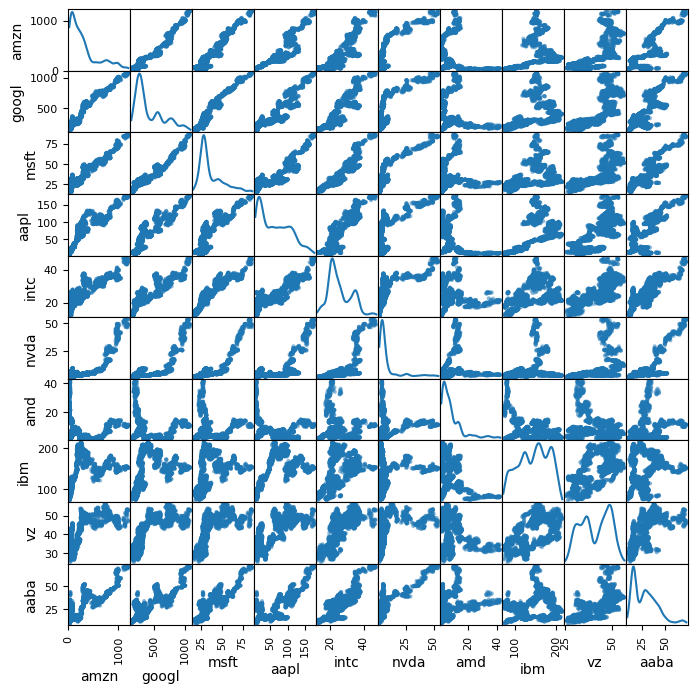

In [26]:
pd.plotting.scatter_matrix(data, figsize = (8,8), diagonal = 'kde')
plt.show()

In [32]:
def adfullertest(data, column_name, difference_order=0):
    if difference_order > 0:
        differenced_data = data[column_name].diff(difference_order).dropna()
        result = adfuller(differenced_data)
        print(f'ADF Statistic for {column_name} (Differencing Order {difference_order}): {result[0]}')
        print(f'p-value for {column_name} (Differencing Order {difference_order}): {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print('Is Stationary:', result[1] < 0.05)
    else:
        result = adfuller(data[column_name])
        print(f'ADF Statistic for {column_name}: {result[0]}')
        print(f'p-value for {column_name}: {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print('Is Stationary:', result[1] < 0.05)

    
#ssuming 'data' is your DataFrame with a datetime index and multiple variables
for column in data.columns[1:]:
    adfullertest(data,column)


ADF Statistic for amzn: 2.9638082255195877
p-value for amzn: 1.0
Critical Values:
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
Is Stationary: False
ADF Statistic for googl: 1.3224241360302167
p-value for googl: 0.9967315857800989
Critical Values:
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
Is Stationary: False
ADF Statistic for msft: 2.1707913697890535
p-value for msft: 0.9988575993461946
Critical Values:
   1%: -3.4325265517435293
   5%: -2.8625016602846984
   10%: -2.567281916911753
Is Stationary: False
ADF Statistic for aapl: 0.552367204190558
p-value for aapl: 0.9863807814299046
Critical Values:
   1%: -3.4325345499510043
   5%: -2.8625051928165557
   10%: -2.5672837975912697
Is Stationary: False
ADF Statistic for intc: -0.1282667375765534
p-value for intc: 0.9465492557585924
Critical Values:
   1%: -3.4325294533972204
   5%: -2.862502941845959
   10%: -2.567282599200112
Is Stationary: False
ADF Statistic for 

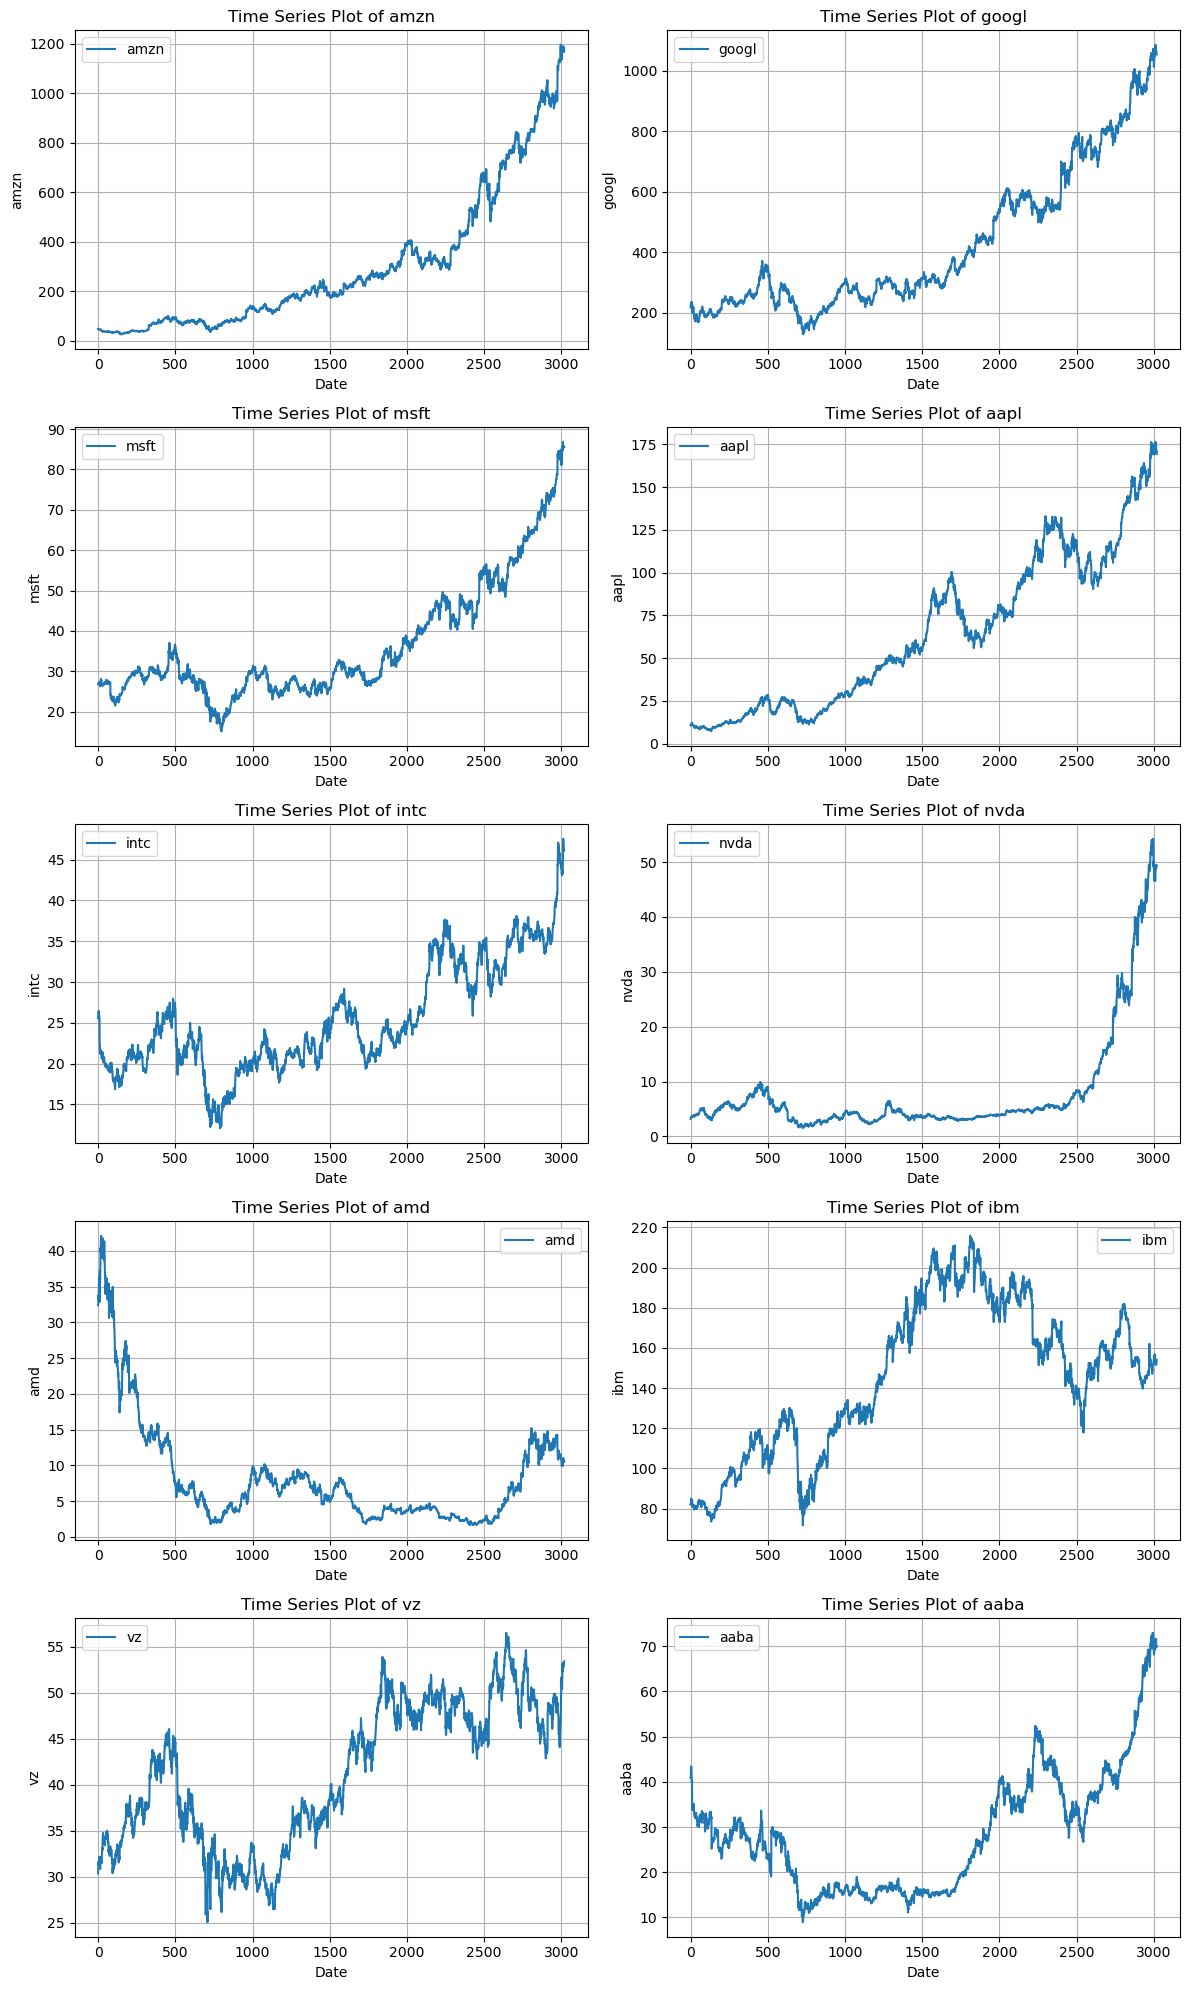

In [33]:
variables_to_plot = data.columns[1:] 

num_variables = len(variables_to_plot)
num_rows = (num_variables + 1) // 2  
num_cols = 2 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array if it's not already flat
if num_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for i, variable in enumerate(variables_to_plot):
    row = i // num_cols
    col = i % num_cols

    axes[i].plot(data.index, data[variable], label=variable)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(variable)
    axes[i].set_title('Time Series Plot of ' + variable)
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused subplots
for j in range(num_variables, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [34]:
stationary = data.copy()

In [41]:
adfuller_amzn = adfullertest(stationary, 'amzn', 1)
adfuller_googl = adfullertest(stationary, 'googl', 1)
adfuller_msft = adfullertest(stationary, 'msft', 1)
adfuller_aapl = adfullertest(stationary, 'aapl', 1)
adfuller_intc = adfullertest(stationary, 'intc', 1)
adfuller_nvda = adfullertest(stationary, 'nvda', 1)
adfuller_ibm = adfullertest(stationary, 'ibm', 1)
adfuller_vz = adfullertest(stationary, 'vz', 1)
adfuller_aaba = adfullertest(stationary, 'aaba', 1)

adfuller_amzn
adfuller_googl
adfuller_msft
adfuller_aapl
adfuller_intc
adfuller_nvda
adfuller_ibm
adfuller_vz
adfuller_aaba

ADF Statistic for amzn (Differencing Order 1): -10.094753795777912
p-value for amzn (Differencing Order 1): 1.0983139936571981e-17
Critical Values:
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
Is Stationary: True
ADF Statistic for googl (Differencing Order 1): -10.715538736001102
p-value for googl (Differencing Order 1): 3.2487316502660533e-19
Critical Values:
   1%: -3.432540403849221
   5%: -2.862507778275112
   10%: -2.5672851740608125
Is Stationary: True
ADF Statistic for msft (Differencing Order 1): -17.15856610624812
p-value for msft (Differencing Order 1): 6.866235433795143e-30
Critical Values:
   1%: -3.4325265517435293
   5%: -2.8625016602846984
   10%: -2.567281916911753
Is Stationary: True
ADF Statistic for aapl (Differencing Order 1): -11.195686633549675
p-value for aapl (Differencing Order 1): 2.3096464854099648e-20
Critical Values:
   1%: -3.4325345499510043
   5%: -2.8625051928165557
   10%: -2.5672837975912697
Is Stationary: True
ADF 

ADF Statistic for amzn (Differencing Order 1): -10.094753795777912
p-value for amzn (Differencing Order 1): 1.0983139936571981e-17
Critical Values:
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
Is Stationary: True


In [43]:
def local_average(df, column_name ,window_size):
    df['MA_' + column_name] = df[column_name].rolling(window = window_size).mean()
    return df


In [57]:
local_average(stationary, 'amzn', 365)
adfullertest(stationary.dropna(), 'MA_amzn')

ADF Statistic for MA_amzn: 2.9803581566562913
p-value for MA_amzn: 1.0
Critical Values:
   1%: -3.4328350737532487
   5%: -2.8626379169370946
   10%: -2.5673544595439926
Is Stationary: False


In [ ]:
sns.lineplot(data = stationary.dropna(), x = stationary.Date, y = stationary.MA_amzn)

In [63]:
stationary['sqrt_amzn'] = np.log(stationary['amzn'])
adfullertest(stationary, 'sqrt_amzn')

ADF Statistic for sqrt_amzn: -0.1085225175812586
p-value for sqrt_amzn: 0.9485830136862611
Critical Values:
   1%: -3.4325200511877854
   5%: -2.862498789206885
   10%: -2.567280388383968
Is Stationary: False


In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(stationary['amzn'], model='additive', period=seasonal_period)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

NameError: name 'seasonal_period' is not defined

In [ ]:
#gar sage model
#jointly or seperately
#for ar model, vectorized model
#figure out differencing order